In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lastfm import get_lastfm_genre

In [ ]:
tracks_df = pd.read_csv('tracks.csv')
tracks_df.head()

In [ ]:
artists_df = pd.read_csv('artists.csv')
artists_df.head()

In [ ]:
# Gets missing genre information from lastfm and saves it as a CSV
na_genres_df = artists_df[artists_df['genres'].isna()]
# # na_genres_df = na_genres_df[na_genres_df['artist_name'].unique()]
# for index, row in na_genres_df.iterrows():
#     print(index, row['artist_name'])
#     if row['artist_name']:
#         genre = get_lastfm_genre(row['artist_name'])
#         print(genre)
#         if genre:
#             na_genres_df.loc[index, 'genres'] = genre
# na_genres_df.to_csv('artists_missing_genres.csv', index=False)
len(na_genres_df)


In [ ]:
# Update with missing genres
missing_genres_df = pd.read_csv('artists_missing_genres.csv')
artists_merged_df = pd.merge(artists_df, missing_genres_df[['id', 'genres']], on='id', how='left')
artists_df['genres'] = artists_df['genres'].fillna(artists_merged_df['genres_y'])

# Clean genre strings
artists_df['genres'] = [g.lower().replace('-',' ') if not isinstance(g, float) else g for g in artists_df['genres']]
print(len(artists_df[artists_df['genres'].isna()]))
# # Identify artists with unique genres to check for inaccuracies
# genre_counts = artists_df['genres'].value_counts()
# unique_genres = artists_df[artists_df['genres'].isin(genre_counts[genre_counts == 1].index)]
# unique_genres.sort_values(by='genres')

In [ ]:

corrected_genres = {
    'Saweetie': 'hip hop',
    'Vana': 'pop metal',
    'FWLR': 'bass house',
    'gladde paling': 'memetechno',
    'ShogunF': 'electronic',
    'Garrett Williamson': 'video game music',
    'WHIPPED CREAM': 'edm'
}
corrected_genres_df = pd.DataFrame.from_dict(corrected_genres, orient='index', columns=['genres'])
corrected_genres_df  = corrected_genres_df.reset_index(names='artist_name')
artists_merged_df_2 = artists_df.merge(corrected_genres_df, on='artist_name', how='left')

artists_merged_df_2['genres_x'] = artists_merged_df_2['genres_x'].where(artists_merged_df_2['genres_y'] != np.nan, artists_merged_df_2['genres_y'])
artists_df['genres'] = artists_merged_df_2['genres_x']

# Handle remaining null values
artists_df['genres'] = artists_df['genres'].fillna('unknown')

In [ ]:
# Convert added at into date, time, and day of week
tracks_df['added_at'] = pd.to_datetime(tracks_df['added_at'], utc=True)
tracks_df['added_at_date'] = tracks_df['added_at'].dt.date
tracks_df['added_at_time'] = tracks_df['added_at'].dt.time
tracks_df['added_at_dow'] = tracks_df['added_at'].dt.day_name()

# Convert release date into date
tracks_df['album_release_date'] = pd.to_datetime(tracks_df['album_release_date'], format='mixed', utc=True)
tracks_df['release_year'] = tracks_df['album_release_date'].dt.year
tracks_df['release_add_delta'] = round((tracks_df['added_at'] - tracks_df['album_release_date']).astype(np.int64) / (60 * 60 * 24 * 10**9)) # Days
# merge
artists_df= artists_df.rename(columns={'id': 'artist_id'})
merged_df = pd.merge(tracks_df, artists_df, on='artist_id')

# Clean dupicate columns
merged_df = merged_df.rename(columns={'popularity_x': 'track_popularity', 'popularity_y': 'artist_popularity', 'followers': 'artist_followers', 'artist_name_x':'artist_name'})
merged_df.drop(columns='artist_name_y', inplace=True)
merged_df.head()



In [ ]:
sns.lineplot(data=tracks_df, x='added_at', y='release_add_delta')

In [ ]:
sns.histplot(tracks_df['release_add_delta'])
# tracks_df[tracks_df['artist_id'] == '6MF58APd3YV72Ln2eVg710']

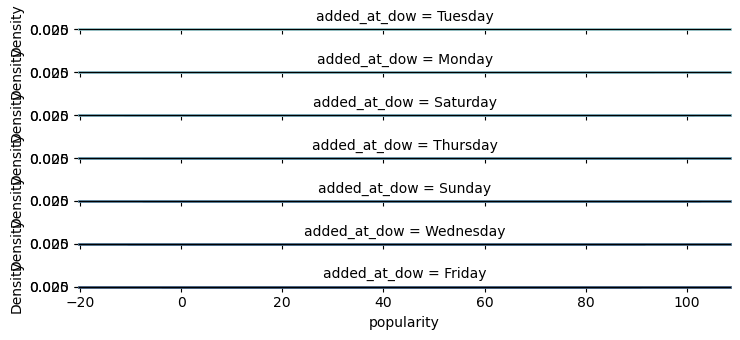

In [41]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tracks_df, row="added_at_dow", hue="added_at_dow", aspect=15, height=.5, palette=pal)

g.map(sns.kdeplot, "popularity",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "popularity", clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


In [ ]:

sns.histplot(tracks_df_sort['added_at_dow'])

plt.xticks(rotation=45)

In [ ]:
sns.histplot(merged_df['release_year'])

In [ ]:
tracks_df.plot(y='popularity', x='release_year',kind='scatter')

In [ ]:
value_counts = artists_df['genres'].value_counts()
# filtered_genres = artists_df[artists_df['genres'].isin(value_counts[value_counts > 2].index)]
sns.barplot(value_counts[value_counts > 2])
plt.xticks(rotation=45)

In [ ]:
artist_counts = tracks_df['artist_name'].value_counts()
artist_counts.head()

In [ ]:
sns.histplot(artists_df['popularity'])

In [ ]:
sns.histplot(tracks_df['popularity'])

In [ ]:
# sns.histplot(merged_df['added_at_date'])

saves_by_date = merged_df.groupby(['added_at_date']).agg({'track_id': 'count', 'added_at_dow': 'first'})
saves_by_date.rename(columns={'track_id':'tracks_saved'}, inplace=True)
saves_by_date = saves_by_date.reset_index()
# saves_by_date.describe()
saves_by_date = saves_by_date.sort_values(by='added_at_date')
start_date =saves_by_date.head(1)
end_date =saves_by_date.tail(1)
full_date_range = pd.DataFrame()
saves_by_date['added_at_date'] = pd.to_datetime(saves_by_date['added_at_date'], utc=True)
full_date_range['added_at_date'] = pd.date_range(start=start_date['added_at_date'][0],end=end_date['added_at_date'][154])
full_date_range['added_at_date'] = pd.to_datetime(full_date_range['added_at_date'], utc=True)

full_date_range = full_date_range.merge(saves_by_date, on='added_at_date', how='left')
# saves_by_date
full_date_range['tracks_saved'] = full_date_range['tracks_saved'].fillna(0)
# full_date_range


full_date_range['added_at_week'] = full_date_range['added_at_date'].dt.isocalendar().week
full_date_range['added_at_week_date'] = full_date_range['added_at_date'] - pd.to_timedelta(full_date_range['added_at_date'].dt.weekday, unit='D')

sns.lineplot(data=full_date_range,x='added_at_week_date', y='tracks_saved')
plt.xticks(rotation=45)
# sns.histplot(full_date_range['tracks_saved'])

In [ ]:
agg_data = full_date_range.groupby('added_at_week_date')['tracks_saved'].agg(['min', 'max', 'mean']).reset_index()
# Plot the mean line
sns.lineplot(data=agg_data, x='added_at_week_date', y='mean', label='Average')

# Add min and max as a shaded area
plt.fill_between(agg_data['added_at_week_date'], agg_data['min'], agg_data['max'], alpha=0.2, label='Min-Max Range')

plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
import matplotlib.dates as mdates
full_date_range['added_at_month'] = full_date_range['added_at_date'].dt.to_period('M')
july = full_date_range[full_date_range['added_at_month'] == '2024-07']

agg_data_july = july.groupby('added_at_week_date')['tracks_saved'].agg(['min', 'max', 'mean']).reset_index()

# Plot the mean line
# sns.lineplot(data=agg_data_july, x='added_at_week_date', y='mean', label='Average')
sns.lineplot(data=july, x='added_at_date', y='tracks_saved')
# Add min and max as a shaded area
# plt.fill_between(agg_data_july['added_at_week_date'], agg_data_july['min'], agg_data_july['max'], alpha=0.2, label='Min-Max Range')

plt.xticks(rotation=45)
# Set x-axis to show every day
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show every day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD
plt.legend()
plt.show()

In [ ]:
# Want best time slots to advertise new pop music
# Look at genre over saved date/time
# 

# User stories, Jacq vs Merc vs Luis, can we be categorized into different "types" of users
# What characteristics define those users?
# New music seeker vs Merc songs of the week

# What kind of spotify user am I?

In [ ]:
sns.scatterplot(data=merged_df, y='added_at_date', x='release_year')
# X = added at date, 
# release time - added at date
# How long between release and save date? How long does it take my listener to save new music after it's released?
# Populartiy by release year
